### Get Historical Data

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
import pandas_datareader as pdr
from datetime import datetime, timedelta

In [3]:
import yfinance as yf

def get_historical_data(start, end, tickers):
    data = pd.DataFrame()
    names = list()
    for i in tickers:
        data = pd.concat([data, pd.DataFrame(yf.download(i, start=start, end=end))], axis = 1)['Close']
        names.append(i)
    data.columns = names
    return data

### Set Start and End Datetime

In [4]:
start = datetime(2018, 1, 1)
end = datetime(2022, 12, 31)

In [40]:
instrument_1 = 'AAPL'
instrument_2 = 'MSFT'
tickers= [instrument_1, instrument_2] # Can put more instruments

In [41]:
df = get_historical_data(start, end, tickers)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [42]:
df

,AAPL,MSFT
Date,,
2018-01-02,43.064999,85.949997
2018-01-03,43.057499,86.349998
2018-01-04,43.257500,87.110001
2018-01-05,43.750000,88.190002
2018-01-08,43.587502,88.279999
...,...,...
2022-12-23,131.860001,238.729996
2022-12-27,130.029999,236.960007
2022-12-28,126.040001,234.529999


### Plot 2 Instruments

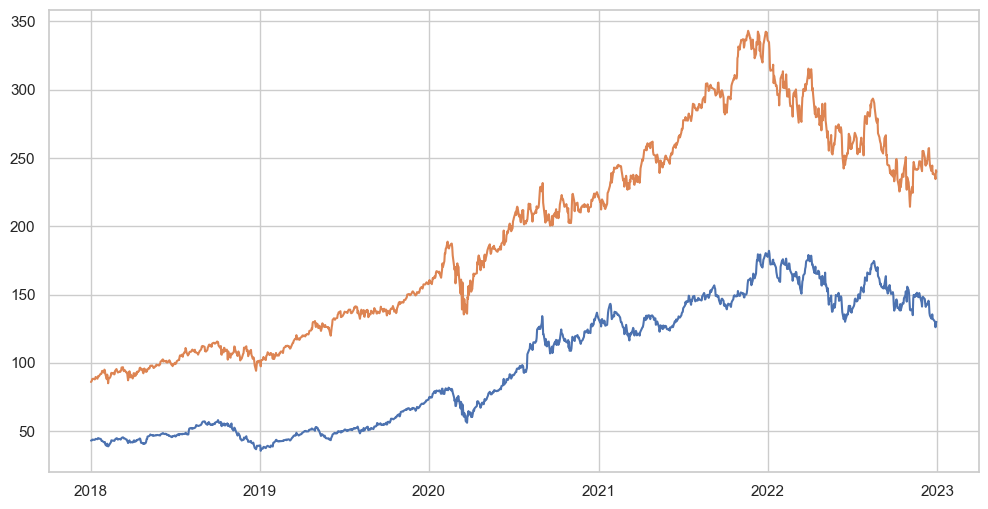

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df[instrument_1], label=instrument_1)
plt.plot(df.index, df[instrument_2], label=instrument_2)

In [44]:
corr_matrix = df.corr()
corr_matrix

,AAPL,MSFT
AAPL,1.000000,0.972166
MSFT,0.972166,1.000000


### Visualize Stationarity Between 2 Instruments

In [45]:
def find_cointegrated_score(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            
            combined = pd.concat([S1, S2], axis=1)
            combined = combined.dropna()
            S1 = combined.iloc[:, 0]
            S2 = combined.iloc[:, 1]
            
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            pairs.append([keys[i], keys[j]])
    return score_matrix, pvalue_matrix, pairs

In [46]:
scores, pvalues, pairs = find_cointegrated_score(df)
print(pvalues)

[[1.        0.2022347]
 [1.        1.       ]]


In [48]:
def spread(S1_key, S2_key):
    
    S1 = df[S1_key]
    S2 = df[S2_key]
    
    S1 = S1.dropna()
    S2 = S2.dropna()
    
    S1, S2 = S1.align(S2, join='inner')
    
    S1 = sm.add_constant(S1)
    results = sm.OLS(S2, S1).fit()
    S1 = S1[S1_key]
    b = results.params[S1_key]
    
    spread = S2 - b * S1
    std = np.std(spread)
    
    plt.scatter(S1, S2, label='Data')
    plt.plot(S1, results.fittedvalues, color='red', label='OLS Regression Line')
    plt.xlabel(S1_key)
    plt.ylabel(S2_key)
    plt.title(f'OLS Regression: {S2_key} vs {S1_key}')
    plt.legend()
    plt.show()
    
    return [b, spread.mean(), std]

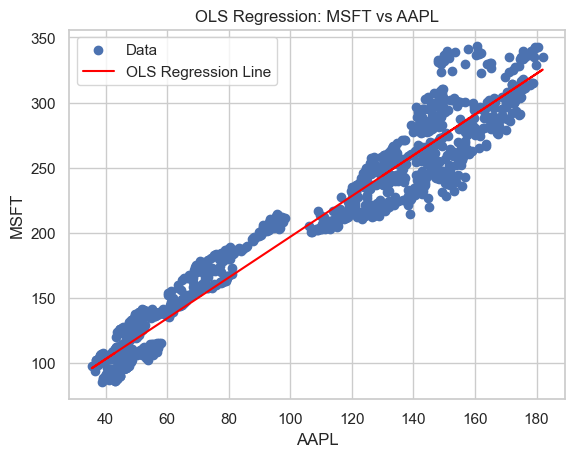

[1.5663083449372934, 40.22972377314774, 17.47407552613191]


In [49]:
print(spread(instrument_1, instrument_2))

results                             OLS Regression Results                            
Dep. Variable:                   MSFT   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                 2.164e+04
Date:                Sun, 14 Jul 2024   Prob (F-statistic):               0.00
Time:                        00:37:24   Log-Likelihood:                -5388.1
No. Observations:                1259   AIC:                         1.078e+04
Df Residuals:                    1257   BIC:                         1.079e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.2297      1.155     34.836 

Text(0.5, 0, 'AAPL and MSFT')

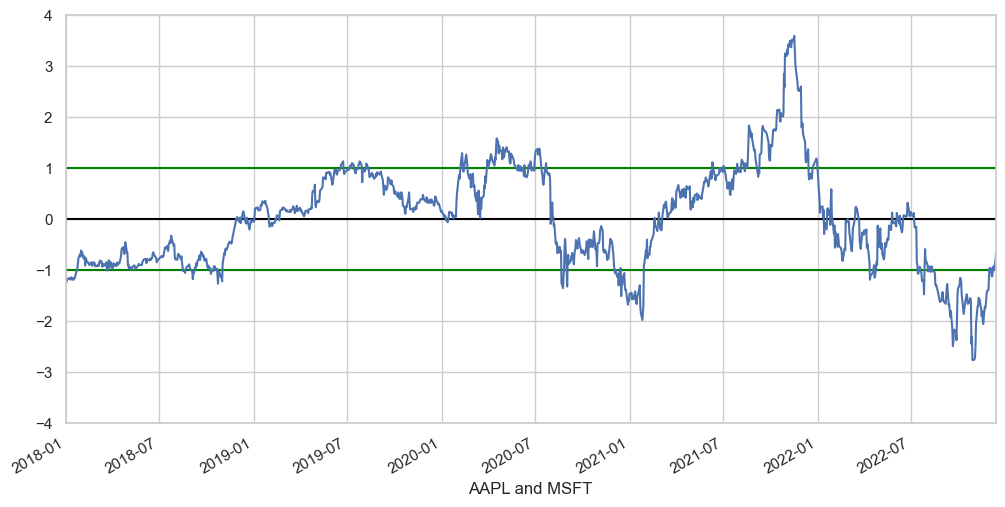

In [63]:
S1 = df[instrument_1]
S2 = df[instrument_2]

S1 = S1.dropna()
S2 = S2.dropna()

S1, S2 = S1.align(S2, join='inner')

S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1[instrument_1]
b = results.params[instrument_1]
print("results", results.summary())

spread = S2 - b * S1
plt.axhline(1, color='green')
plt.axhline(-1, color='green')
plt.axhline(0, color='black')
zscore = (spread - spread.mean()) / np.std(spread)
zscore.plot(figsize=(12,6))
plt.ylim(-4, 4) 
plt.xlim('2018-01-01', '2022-12-12') 
plt.xlabel(f'{instrument_1} and {instrument_2}')

### Visualize Entry and Exit Signal

In [52]:
S1 = df[instrument_1]
S2 = df[instrument_2]

S1

Date
2018-01-02     43.064999
2018-01-03     43.057499
2018-01-04     43.257500
2018-01-05     43.750000
2018-01-08     43.587502
                 ...    
2022-12-23    131.860001
2022-12-27    130.029999
2022-12-28    126.040001
2022-12-29    129.610001
2022-12-30    129.929993
Name: AAPL, Length: 1259, dtype: float64

In [54]:
S1 = df[instrument_1]
b = results.params[instrument_1]

b

1.5663083449372934

In [55]:
ratios = S1 / S2
print(len(ratios) * .70 ) 

881.3


In [56]:
train = ratios[:680]
test = ratios[680:]

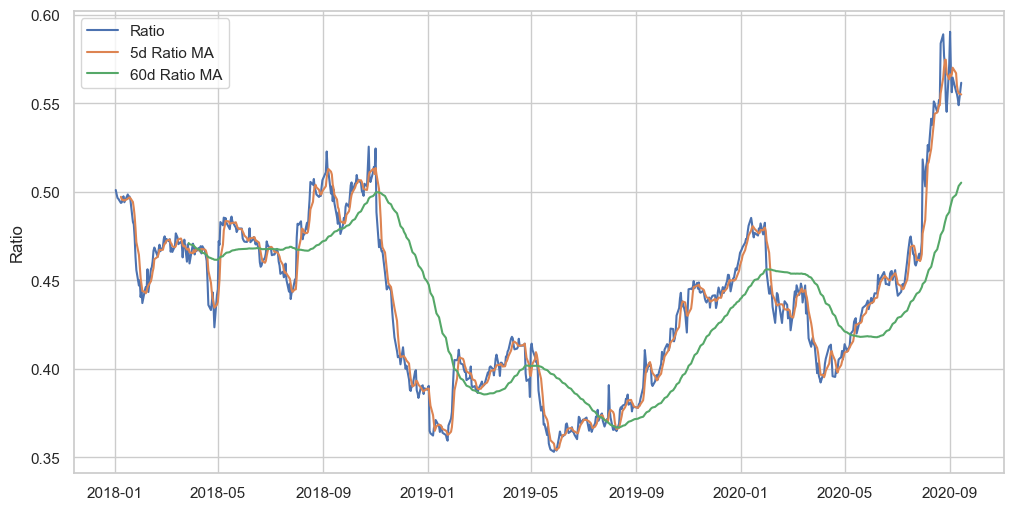

In [57]:
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

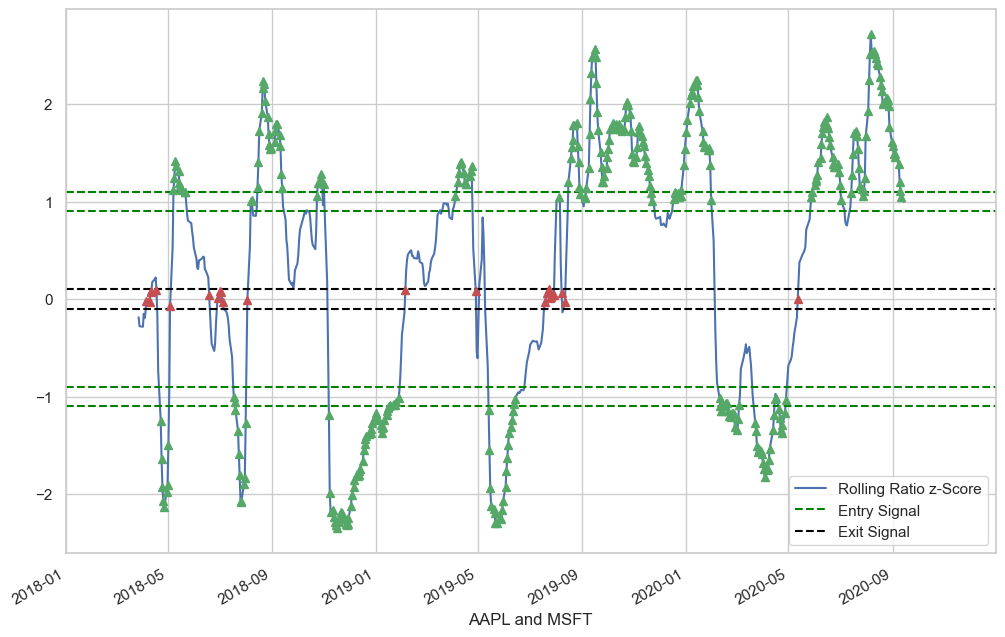

In [59]:
plt.figure(figsize=(12,8))
zscore_60_5.plot()
plt.xlim('2018-01-01', '2020-12-31')
plt.axhline(1.10, color='green', linestyle='--')
plt.axhline(0.1, color='black', linestyle='--')
# plt.axhline(-1.2, color='red', linestyle='--')

plt.axhline(-0.1, color='black', linestyle='--')
plt.axhline(1.10, color='green', linestyle='--')
plt.axhline(0.9, color='green', linestyle='--')
plt.axhline(-1.10, color='green', linestyle='--')
plt.axhline(-0.9, color='green', linestyle='--')
# plt.axhline(1.2, color='red', linestyle='--')

# Plot markers based on conditions
# entry_signal = zscore_60_5[((zscore_60_5 >= 0.9) & (zscore_60_5 <= 1.1)) | ((zscore_60_5 >= -1.1) & (zscore_60_5 <= -0.9))]
entry_signal = zscore_60_5[(zscore_60_5 >= 1) | (zscore_60_5 < -1)]
exit_signal = zscore_60_5[((zscore_60_5 >= 0) & (zscore_60_5 <= 0.1)) | ((zscore_60_5 >= -0.1) & (zscore_60_5 <= 0))]
# exit_signal = zscore_60_5[(zscore_60_5 > 1.2) | (zscore_60_5 < -1.2) | ((zscore_60_5 >= 0) & (zscore_60_5 <= 0.1)) | ((zscore_60_5 >= -0.1) & (zscore_60_5 <= 0))]
entry_signal.plot(color='g', linestyle='None', marker='^')
exit_signal.plot(color='r', linestyle='None', marker='^')

plt.legend(['Rolling Ratio z-Score', 'Entry Signal', 'Exit Signal'])
plt.xlabel(f"{instrument_1} and {instrument_2}")
plt.show()

### Finding The Right Volume